In [30]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim
import time
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Dataset
https://www.kaggle.com/c/nyc-taxi-trip-duration/data

# 1a: Read, preprocess, and print main statistics about the dataset

In [22]:
# Pandas Dataframe
train_df = pd.read_csv("nyc-taxi-trip-duration/train.csv")

In [5]:
print("Dataset Shape:", train_df.shape)

Dataset Shape: (1458644, 11)


In [6]:
print("\nData types of each column:")
train_df.dtypes


Data types of each column:


id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [7]:
print("\nDataset Info:")
train_df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
print("\nDataset Statistics:")
train_df.describe()


Dataset Statistics:


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [9]:
# Display first five rows of dataframe
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# 1b: Data Visualization

In [14]:
palette_color = sns.color_palette('bright') 

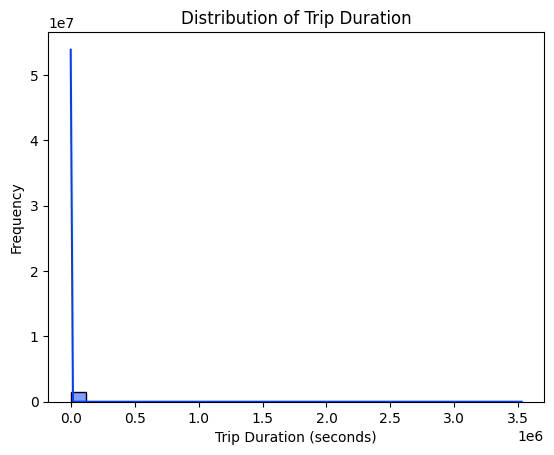

In [15]:
# Visualization 1: Histogram of trip duration
sns.histplot(train_df['trip_duration'], bins=30, kde=True, color=palette_color[0])
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

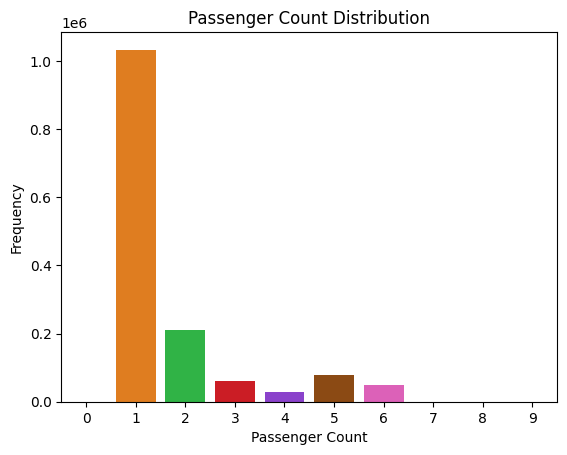

In [16]:
# Visualization 2: Count plot of passenger count
sns.countplot(data=train_df, x='passenger_count', palette=palette_color)
plt.title('Passenger Count Distribution')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()

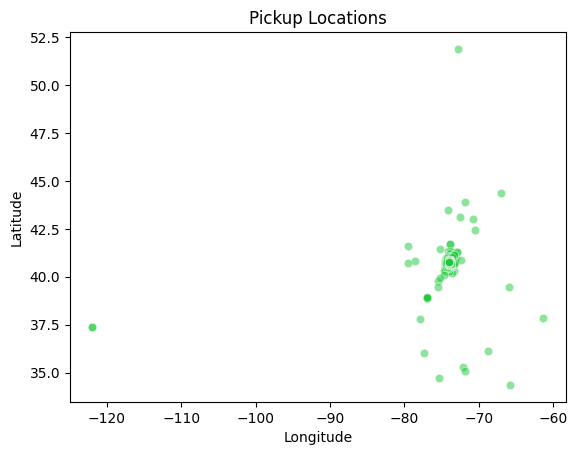

In [17]:
# Visualization 3: Scatter plot of pickup locations
sns.scatterplot(data=train_df, x='pickup_longitude', y='pickup_latitude', alpha=0.5, color=palette_color[2])
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# 1c: Prepare the dataset for training

In [23]:
# Preprocessing
# Drop unnecessary columns
train_df.drop(columns=['id', 'dropoff_datetime', 'store_and_fwd_flag'], inplace=True)

# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for column in train_df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    train_df[column] = label_encoders[column].fit_transform(train_df[column])

# Normalize numerical features
scaler = StandardScaler()
numerical_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])

# Split features and target
X = train_df.drop(columns=['trip_duration'])
y = train_df['trip_duration']

# Split dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training, validation, and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

In [24]:
# Print the shape of each tensor
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([1166915, 7])
X_val_tensor shape: torch.Size([145864, 7])
X_test_tensor shape: torch.Size([145865, 7])
y_train_tensor shape: torch.Size([1166915])
y_val_tensor shape: torch.Size([145864])
y_test_tensor shape: torch.Size([145865])


### LSTM Model Architecture

In [25]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropoutAdd=False):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropoutAdd = dropoutAdd
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim,
                          batch_first=True, dropout=0.5 if dropoutAdd else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Add a sequence length dimension
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        out, _ = self.rnn(x, h0)
        if self.dropoutAdd:
            # Apply dropout
            out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [26]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]  
hidden_size = 32
num_layers = 3
output_size = 1

In [27]:
# Print the model architecture
print(RNN(input_size, hidden_size, num_layers, output_size, dropoutAdd=False))

RNN(
  (rnn): RNN(7, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [39]:
def modelTraining(model, criterion, optimizer, earlyStopping=False):
    import time

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    epochs = 20
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss_training = criterion(outputs.squeeze(), targets)
            loss_training.backward()
            optimizer.step()

            running_loss += loss_training.item()

            if i % 5000 == 4999:
                validation_loss = 0.0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        outputs = model(inputs)
                        loss_validation = criterion(outputs.squeeze(), targets)
                        validation_loss += loss_validation.item()

                testing_loss = 0.0
                with torch.no_grad():
                    for inputs, targets in test_loader:
                        outputs = model(inputs)
                        loss_testing = criterion(outputs.squeeze(), targets)
                        testing_loss += loss_testing.item()

                training_loss = round((running_loss / 5000), 3)
                validation_loss = round((validation_loss / len(val_loader)), 3)
                testing_loss = round((testing_loss / len(test_loader)), 3)

                print(
                    f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

                training_loss_plt_arr.append(training_loss)
                validation_loss_plt_arr.append(validation_loss)
                testing_loss_plt_arr.append(testing_loss)
                running_loss = 0.0

                # Early stopping condition
                if earlyStopping:
                    if validation_loss < previous_number:
                        previous_number = validation_loss
                        consecutive_count = 0
                    else:
                        consecutive_count += 1
                        max_consecutive = max(
                            max_consecutive, consecutive_count)
                        if max_consecutive == 5:
                            print(
                                "\nStopping training as Validation Loss stopped improving.")
                            break

        if earlyStopping:
            if max_consecutive == 5:
                break

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr

In [32]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [34]:
# Updated Performance Evaluation
def perfEvaluation(model, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')

    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            true_labels.extend(targets.tolist())

    r2 = r2_score(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)
    mse = mean_squared_error(true_labels, predictions)

    print(f'R² Score: {r2:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Squared Error: {mse:.4f}')


In [40]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = 1

RNN_M1 = RNN(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=False)

criterion_M1 = nn.MSELoss()
optimizer_M1 = optim.Adam(RNN_M1.parameters(), lr=0.0001)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=RNN_M1, criterion=criterion_M1,
                                                                                     optimizer=optimizer_M1, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=RNN_M1, criterion=criterion_M1)

[1, 5000], Training loss: 11631106.151, Validation loss: 12617084.181, Testing loss: 10341772.339
[1, 10000], Training loss: 10471652.982, Validation loss: 12590284.276, Testing loss: 10315697.594
[1, 15000], Training loss: 42044728.575, Validation loss: 12568896.912, Testing loss: 10294896.717
[1, 20000], Training loss: 10120583.676, Validation loss: 12543019.185, Testing loss: 10269738.675
[1, 25000], Training loss: 10119390.79, Validation loss: 12517506.63, Testing loss: 10244946.517
[1, 30000], Training loss: 138089347.756, Validation loss: 12503196.289, Testing loss: 10231044.944
[1, 35000], Training loss: 11276882.176, Validation loss: 12479566.173, Testing loss: 10208098.322
[2, 5000], Training loss: 65471768.068, Validation loss: 12455073.655, Testing loss: 10184325.481
[2, 10000], Training loss: 9362820.259, Validation loss: 12431427.613, Testing loss: 10161385.124


KeyboardInterrupt: 